In [1]:
import pandas as pd
import matplotlib.pyplot as plt
#import geopandas as gpd
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
import math

In [2]:
import io
import fitter
from ray import *

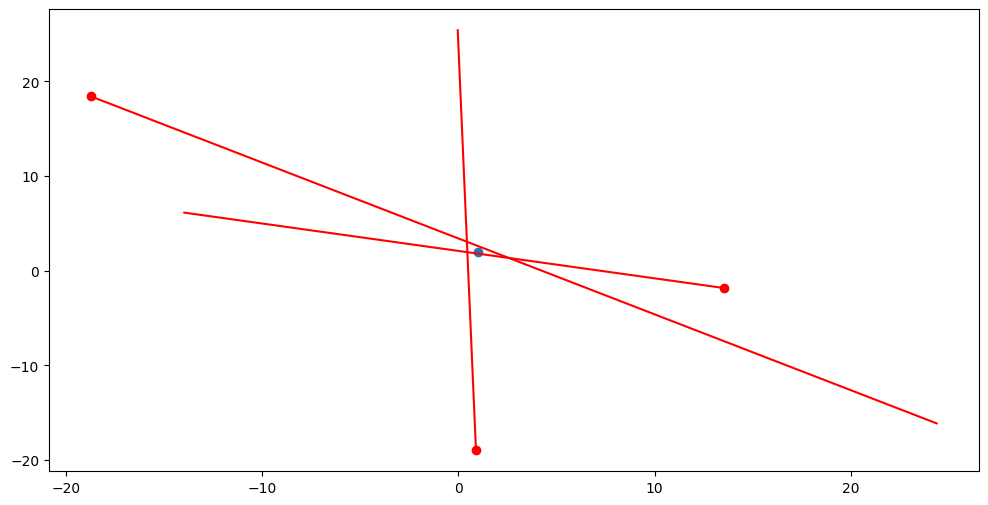

In [12]:
fireLocation = [1,2]
measurements = 3

#generate random origins pointing to the fire
origins=[]
for i in range(measurements):
    or_x = np.random.uniform(-30,30)
    or_y = np.random.uniform(-30,30)
    origin=[or_x,or_y]
    origins.append(origin)

rays = []
d0s=[]
fig, ax = plt.subplots(figsize=(12, 6))

#origins=[[-10,-10],[10,0],[-10,10]]
#angles =[math.pi / 4., math.pi, -math.pi /4.]

for i in range(len(origins)):
    s_angle =  0.1 / math.sqrt(12)
    pointingRay = generatePointingRay(fireLocation,origins[i],sigmaAngle=s_angle)
    
    sigma_x = 0.
    sigma_y = 0.
    rays.append(ray(pointingRay[0],pointingRay[1],pointingRay[2],sigma_angle=0.1))
    #rays[i].printTrack()
    ax.plot(rays[i].plotOrigin,rays[i].plotEnd,color="red")
    ax.scatter(origins[i][0],origins[i][1],color="red")

    
plt.scatter(fireLocation[0],fireLocation[1],marker="o")
plt.show()

In [130]:
df = pd.read_csv('/Users/pf/sw/smokeDet/ai_detections.csv')

## Convert Unix timestamp to datetime
df['datetime'] = pd.to_datetime(df['timestamp_epoch'], unit='s')

# Format the datetime into the desired format
#df['formatted_date'] = df['datetime'].dt.strftime('%d/%m/%y %H:%M:%S')

# Split the datetime in bins of X hours
min_datetime = df['datetime'].min()
max_datetime = df['datetime'].max()
# Generate bins for every 2 hours from min_datetime to max_datetime
h_bins=1
bins = pd.date_range(start=min_datetime, end=max_datetime, freq=f'{h_bins}h')
# Assign each datetime to a bin
df['binned_datetime'] = pd.cut(df['datetime'], bins=bins)
# Convert the bins to a categorical type and assign a numerical code to each bin
df['binned_datetime_code'] = pd.Categorical(df['binned_datetime']).codes


# Split the azimuth in bins
min_datetime = df['azimuth_deg_clockwise_north'].min()
max_datetime = df['azimuth_deg_clockwise_north'].max()
# Create bins for the azimuth values
azimuth_bins = np.linspace(0, 360, 30)
# Assign each datetime to a bin
df['binned_azimuth'] = pd.cut(df['azimuth_deg_clockwise_north'], bins=azimuth_bins)
# Convert the bins to a categorical type and assign a numerical code to each bin
df['binned_azimuth_code'] = pd.Categorical(df['binned_azimuth']).codes


df.head()

,timestamp_epoch,latitude_deg,longitude_deg,azimuth_deg_clockwise_north,confidence,dist_est_lower_mi,dist_est_mi,dist_est_upper_mi,datetime,binned_datetime,binned_datetime_code,binned_azimuth,binned_azimuth_code
0,1719841766,33.966240,-117.288879,170.85,0.350493,21.1500,40.9750,50.000,2024-07-01 13:49:26,"(2024-07-01 13:35:36, 2024-07-01 14:35:36]",0,"(161.379, 173.793]",13
1,1719842007,33.966240,-117.288879,170.98,0.307611,21.1000,41.0750,50.000,2024-07-01 13:53:27,"(2024-07-01 13:35:36, 2024-07-01 14:35:36]",0,"(161.379, 173.793]",13
2,1719842179,37.824326,-120.183594,21.42,0.566541,2.1375,2.4375,2.900,2024-07-01 13:56:19,"(2024-07-01 13:35:36, 2024-07-01 14:35:36]",0,"(12.414, 24.828]",1
3,1719840989,33.861668,-117.204185,189.87,0.751670,9.1250,9.5500,50.000,2024-07-01 13:36:29,"(2024-07-01 13:35:36, 2024-07-01 14:35:36]",0,"(186.207, 198.621]",15
4,1719841124,33.861668,-117.204185,190.10,0.641074,9.1125,9.5375,15.325,2024-07-01 13:38:44,"(2024-07-01 13:35:36, 2024-07-01 14:35:36]",0,"(186.207, 198.621]",15


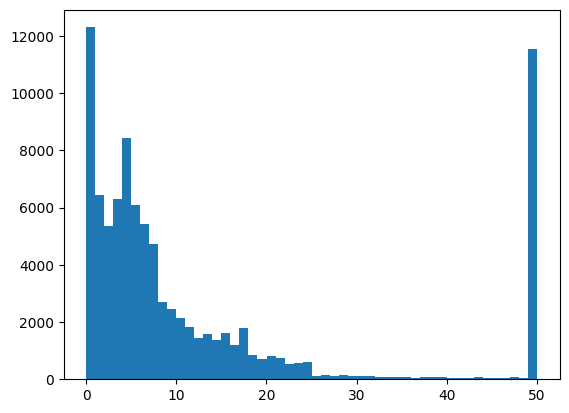

In [143]:
h2 = plt.hist(df["dist_est_mi"],bins=50)

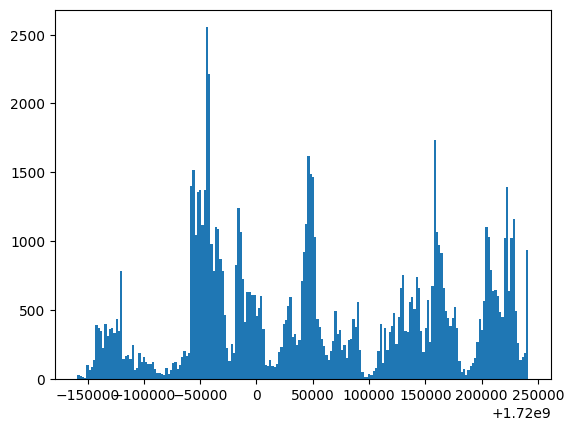

In [131]:
h1 = plt.hist(df["timestamp_epoch"],bins=200)

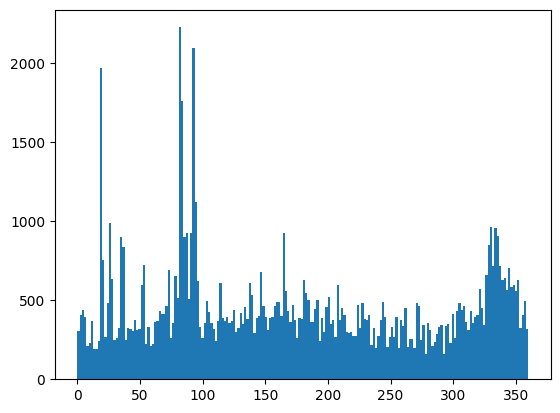

In [132]:
h2 = plt.hist(df["azimuth_deg_clockwise_north"],bins=200)

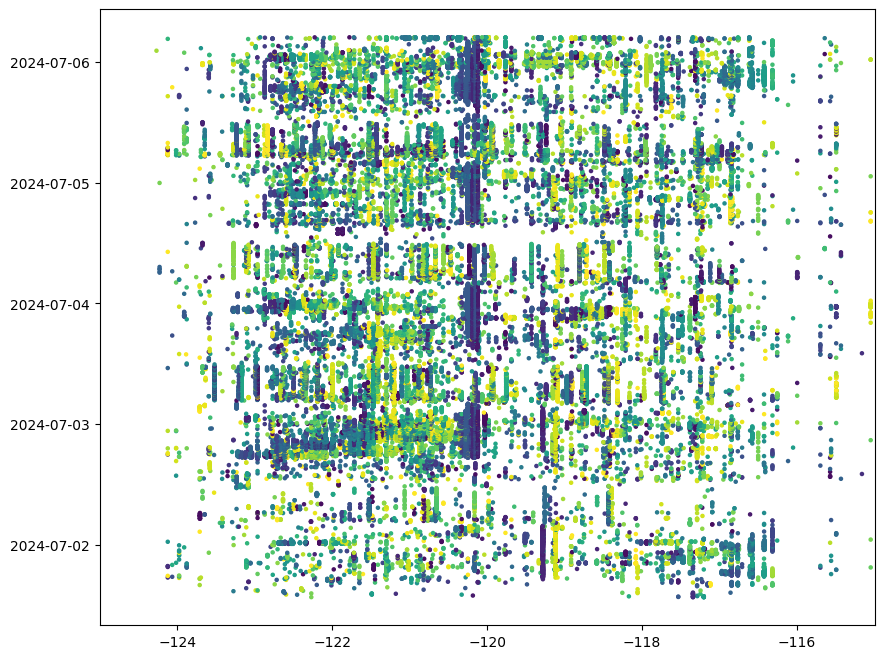

In [133]:
fig = plt.figure(figsize=(10, 8))    
# Single axes in the figure
ax = fig.add_subplot(1, 1, 1)
plt.scatter(df["longitude_deg"],df["datetime"],s=5,c=df['binned_azimuth_code'], cmap='viridis')
ax.set_xlim(-125,-115)
print(figs1)

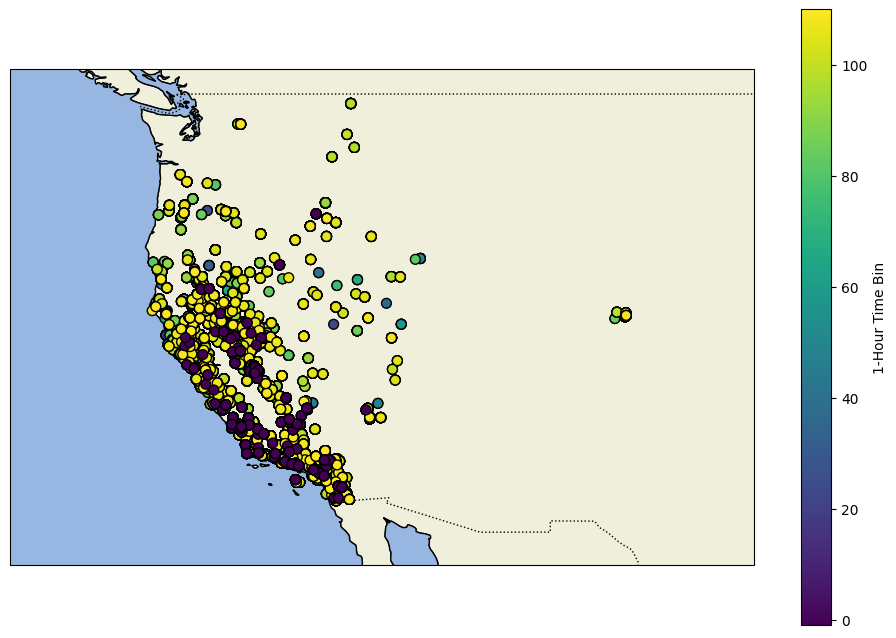

In [134]:
# Create a scatter plot
#fig = plt.figure(figsize=(10, 8))    
# Single axes in the figure
#ax = fig.add_subplot(1, 1, 1)
fig, ax = plt.subplots(figsize=(12, 8), subplot_kw={'projection': ccrs.PlateCarree()})
# Add natural features to the map
ax.add_feature(cfeature.LAND, edgecolor='black')
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')

# Define the extent to zoom into a specific region
# Format: [min_longitude, max_longitude, min_latitude, max_latitude]
ax.set_extent([-130, -100, 30, 50], crs=ccrs.PlateCarree()) # California

#zorder=5 to plot it on top. Color it according to the binned_timestamp_code
scatter = ax.scatter(df["longitude_deg"],df["latitude_deg"], 
                     s=50, c=df['binned_datetime_code'], cmap='viridis', 
                     edgecolor='black', zorder=5)
# Add a colorbar to show which colors correspond to which bins
cbar = plt.colorbar(scatter, ax=ax, orientation='vertical', pad=0.05)
cbar.set_label(f'{h_bins}-Hour Time Bin')

# Plot north-pointing lines for each point
plotLines = False
if plotLines:
    line_length = 0.5
    for lon, lat, azimuth in zip(df['longitude_deg'], df['latitude_deg'],df['azimuth_deg_clockwise_north']):

        azimuth_rad = np.deg2rad(azimuth)
        # Calculate the change in latitude and longitude
        delta_lat = line_length * np.cos(azimuth_rad)
        delta_lon = line_length * np.sin(azimuth_rad) / np.cos(np.deg2rad(lat))
        ax.plot([lon, lon + delta_lon], [lat, lat + delta_lat], color='blue', linewidth=1, zorder=6)

#ax.set_xlim(30, 50)
#ax.set_ylim(-130,-100)

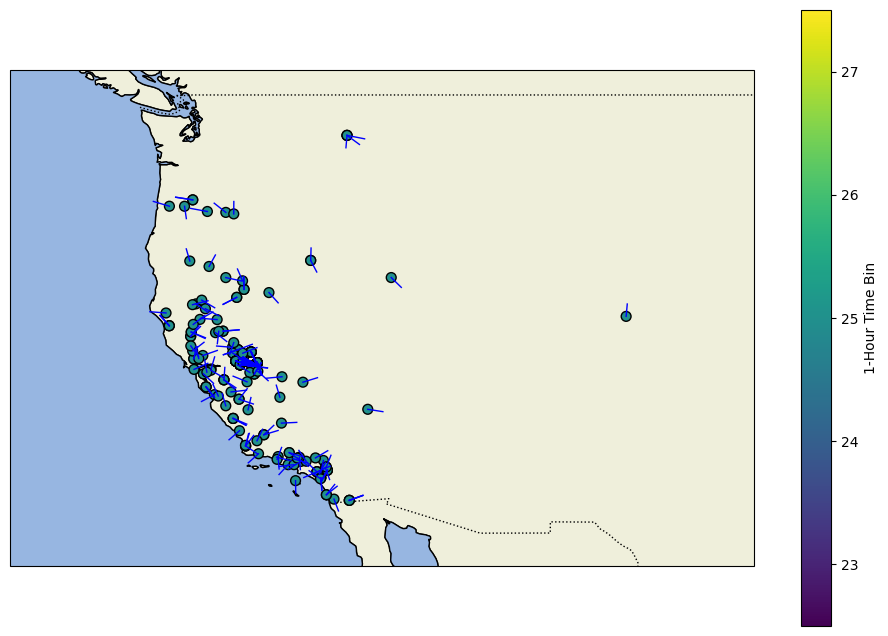

In [149]:
# Plot now only cameras that fired in time stamp bin 0
# Choose a specific bin to filter on
# For example, let's select the first bin
# Split the datetime in bins of X hours
min_datetime_code = df['binned_datetime_code'].min()
max_datetime_code = df['binned_datetime_code'].max()

#for bin in range(min_datetime_code+1,max_datetime_code+1):
#    print(bin)

selected_bin=25
# Filter the DataFrame to include only the rows that fall within the selected bin
df_filtered = df[df['binned_datetime_code'] == selected_bin]
fig, ax = plt.subplots(figsize=(12, 8), subplot_kw={'projection': ccrs.PlateCarree()})
# Add natural features to the map
ax.add_feature(cfeature.LAND, edgecolor='black')
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')

# Define the extent to zoom into a specific region
# Format: [min_longitude, max_longitude, min_latitude, max_latitude]
ax.set_extent([-130, -100, 30, 50], crs=ccrs.PlateCarree()) # California

#zorder=5 to plot it on top. Color it according to the binned_timestamp_code
scatter = ax.scatter(df_filtered["longitude_deg"],df_filtered["latitude_deg"], 
                     s=50, c=df_filtered['binned_datetime_code'], cmap='viridis', 
                     edgecolor='black', zorder=5)
# Add a colorbar to show which colors correspond to which bins
cbar = plt.colorbar(scatter, ax=ax, orientation='vertical', pad=0.05)
cbar.set_label(f'{h_bins}-Hour Time Bin')
# Plot north-pointing lines for each point
plotLines = True
if plotLines:
    line_length = 0.5
    for lon, lat, azimuth in zip(df_filtered['longitude_deg'], df_filtered['latitude_deg'],df_filtered['azimuth_deg_clockwise_north']):

        azimuth_rad = np.deg2rad(azimuth)
        # Calculate the change in latitude and longitude
        delta_lat = line_length * np.cos(azimuth_rad)
        delta_lon = line_length * np.sin(azimuth_rad) / np.cos(np.deg2rad(lat))
        ax.plot([lon, lon + delta_lon], [lat, lat + delta_lat], color='blue', linewidth=1, zorder=6)



In [142]:
# Let's assume that my events are the time bins. 
# 1 - Do I want to cluster measurements in the same time bin?
# 2 - Do I want to clear spurious measurements in the same time bin? 
# 3 - Find all possible intersections from the rays within a certain distance? 
# Create a grid? 


